# Zillow 2017

## Table of Contents

* [Package Imports](#packages_import)
* [Acquire](#data_import)
* [Prepare](#prepare)
* [Explore Process](#explore1)
    * [Question 1](#q_1)
        * [Q1 Visualization](#q_1_viz)
        * [Q1 Statistical Test](#q_1_stats)
        * [Q1 Answer](#q_1_ans)
    * [Question 2](#q_2)
        * [Q2 Visualization](#q_2_viz)
        * [Q2 Statistical Test](#q_2_stats)
        * [Q2 Answer](#q_2_ans)    
    * [Question 3](#q_3)
        * [Q3 Visualization](#q_3_viz)
        * [Q3 Statistical Test](#q_3_stats)
        * [Q3 Answer](#q_3_ans)    
    * [Question 4](#q_4)
        * [Q4 Visualization](#q_4_viz)
        * [Q4 Statistical Test](#q_4_stats)
        * [Q4 Answer](#q_4_ans)
* [Explore Summary](#explore2)
* [Modeling](#modeling)
    * [Introduction](#m_intro)
    * [Baseline](#baseline)
    * [Model 1](#mod_1)
    * [Model 2](#mod_2)
    * [Model 3](#mod_3)
    * [Model 4](#mod_4)
* [Conclusion](#conclusion)
    * [Summery](#c_summery)
    * [Recommendations](#c_recs)
    * [Next Steps](#c_steps)
* [ReadMe](#readme)

## Package Imports <a class="anchor" id="packages_import"></a>


In [1]:
#Import the varius packages
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import normaltest, kstest, norm
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error

from acquire import wrangle_zillow, train_validate, check_p_val, scale_zillow, find_baseline, train_val_test, explore_relationships

In [2]:
#Sets options to show more information
pd.options.display.max_columns = None
pd.options.display.width = 100
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 200

## Concerns

- No sale dates after August.

## Acquire<a class="anchor" id="data_import"></a>

* Data came from Codeup's SQL server who acquired it from a Kaggle challenge.
* Began with 52441 observations and 4 features.

* Acquired on 1/19/2023
* Observation = single family house sold in 2017.
* Column = feature of the house that was sold.

Initial hypothesis is that square footage will be the primary driver. Bedrooms and bathrooms will be the next drivers.

dropping blank values shifted the target mean by -1662 (small amount)

In [3]:
#Get the data from the SQL server and do a bit of cleaning
df = wrangle_zillow()

In [4]:
len(df)

50185

In [5]:
data_dic = pd.read_excel('zillow_data_dictionary.xlsx')
data_dic.iloc[[3, 4, 8, 11, 17, 21, 23, 25, 26, 30, 51]]

,Feature,Description
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
4,'bedroomcnt',Number of bedrooms in home
8,'decktypeid',Type of deck (if any) present on parcel
11,'calculatedfinishedsquarefeet',Calculated total finished living area of the home
17,'fips',Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details
21,'garagecarcnt',Total number of garages on the lot including an attached garage
23,'hashottuborspa',Does the home have a hot tub or spa
25,'latitude',Latitude of the middle of the parcel multiplied by 10e6
26,'longitude',Longitude of the middle of the parcel multiplied by 10e6
30,'poolcnt',Number of pools on the lot (if any)


## Prepare <a class="anchor" id="prepare"></a>

* Dropping the 83 observations with NA values shifted the tax_value mean by -1662 and left 52358 observations to explore.
* After initial exploration, outliers beyond the .99 quantile were dropped, resulting in 50185 observations.

## Explore process <a class="anchor" id="explore1"></a>

* Spearman's R was used due to distributions being right skewed.
* All statistics test used a 95% significance level (alpha = 0.05)

## Observations in Train DataFrame
- 41 where bedrooms = 0. Code: `train[train.bedrooms == 0].describe().T`
- 33 where bathrooms = 0. Code: `train[train.bathrooms == 0].describe().T`
- Bedrooms: min = 0, max = 10
- Bathrooms: min = 0, max = 10
- Mini homes and open/studio style homes might have no bedrooms. Unsure if this applies to bathrooms.

In [6]:
#Creates a list for iteration
train_cols = ['tax_value','bedrooms','bathrooms','sqft']

In [7]:
#Sets variables to automatically pass into functions
random_seed = 1969
alpha = 0.05
target_col = 'tax_value'

In [8]:
#Splits data
train, val, test = train_validate(df)

In [9]:
#Looks at data types
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28103 entries, 21639 to 50012
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tax_value        28103 non-null  float64       
 1   bedrooms         28103 non-null  float64       
 2   bathrooms        28103 non-null  float64       
 3   sqft             28103 non-null  float64       
 4   transactiondate  28103 non-null  datetime64[ns]
 5   hottub_spa       28103 non-null  int64         
 6   deck             28103 non-null  int64         
 7   garagecarcnt     28103 non-null  float64       
 8   pool             28103 non-null  int64         
 9   County           28103 non-null  object        
 10  latitude         28103 non-null  float64       
 11  longitude        28103 non-null  float64       
 12  sqft_bins        28103 non-null  int64         
 13  value_bins       28103 non-null  object        
 14  has_garages      28103 non-null  i

Stats tests: https://datascienceinpractice.github.io/tutorials/11-TestingDistributions.html

### Question 1 <a class="anchor" id="q_1"></a>

- H0: Square feet and tax value are independent variables.
- HA: Square feet and tax value have a relationship.

#### Q1 Visualization <a class="anchor" id="q_1_viz"></a>

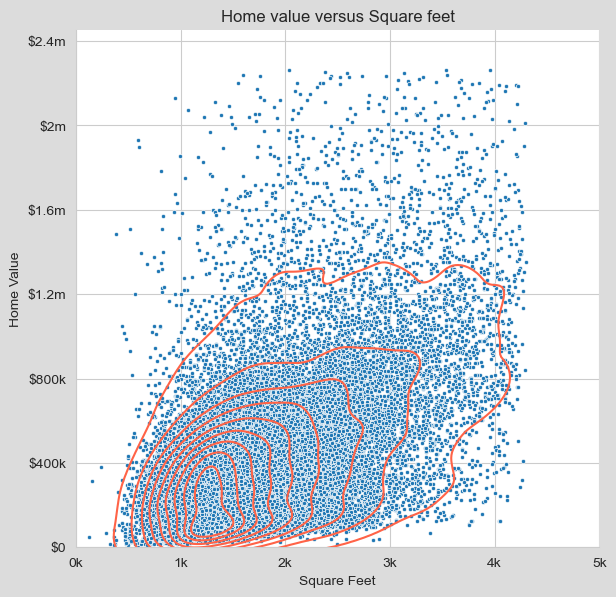

In [10]:
#This graphic only works if you run the notebook cells in order
sns.set_style('whitegrid', rc={'figure.facecolor':'gainsboro'})
sns.relplot(data=train, x='sqft', y='tax_value', marker=".",
            height=6, aspect=1).set(title='Home value versus Square feet',
                                     xlabel="Square Feet",
                                     ylabel="Home Value")

sns.kdeplot(data=train, x='sqft', y='tax_value', c='tomato')
plt.xticks([0, 1000, 2000, 3000, 4000, 5000], ['0k', '1k', '2k', '3k', '4k', '5k'])
plt.yticks([0, 400000,800000,1200000, 1600000, 2000000, 2400000],['$0','$400k','$800k','$1.2m', '$1.6m', '$2m', '$2.4m'])
plt.xlim(left=0, right=5000)
plt.ylim(bottom=0)
plt.show()

#### Q1 Statistical Test <a class="anchor" id="q_1_stats"></a>

In [11]:
#Establishes hypothesis variables
h0 = "Square feet and tax value are independent."
ha = "Square feet and tax value have a relationship."

In [12]:
#Stats test
s, p_val = stats.spearmanr(train['sqft'], train['tax_value'])

#### Q1 Answer <a class="anchor" id="q_1_ans"></a>

In [13]:
#Gives output of stats test
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Square feet and tax value have a relationship.


### Question 2 <a class="anchor" id="q_2"></a>

- H0: Bedroom count and tax value are independent variables.
- HA: Bedroom count and tax value have a relationship.

#### Q2 Visualization <a class="anchor" id="q_2_viz"></a>

In [14]:
metrics = []
num_items = train['bedrooms'].unique()
num_items.sort()
for item in num_items:
    temp_df = train[train['bedrooms'] == item]['tax_value'].describe()
    temp_metrics = {
        'comparison' : f'{item}',
        'count' : round(temp_df[0],0),
        'mean' : round(temp_df[1],0),
        'std' : round(temp_df[2],0),
        'min' : round(temp_df[3],0),
        '25%' : round(temp_df[4],0),
        '50%' : round(temp_df[5],0),
        '75%' : round(temp_df[6],0),
        'max' : round(temp_df[7],0)}
    metrics.append(temp_metrics)

bedrooms_df = pd.DataFrame(metrics)

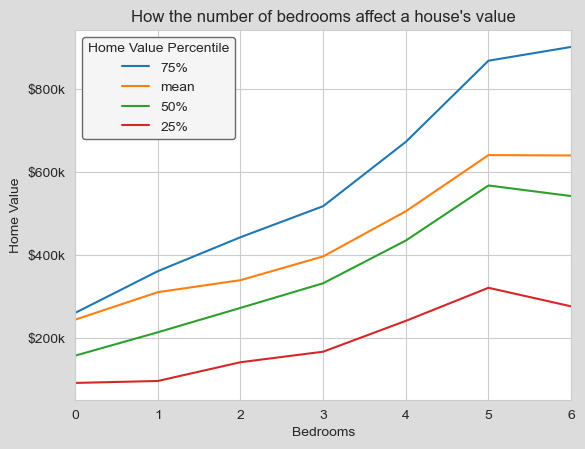

In [15]:
fig, ax = plt.subplots(facecolor='gainsboro', edgecolor='dimgray')
sns.set_style('whitegrid', rc={'figure.facecolor':'gainsboro'})
sns.lineplot(ax=ax, data=bedrooms_df, x='comparison', y='75%', label = '75%').set(title="How the number of bedrooms affect a house's value")
sns.lineplot(ax=ax, data=bedrooms_df, x='comparison', y='mean', label = 'mean')
sns.lineplot(ax=ax, data=bedrooms_df, x='comparison', y='50%' , label = '50%')
sns.lineplot(ax=ax, data=bedrooms_df, x='comparison', y='25%', label = '25%')
plt.xlim(left=0, right =3)
plt.ylabel('Home Value')
plt.xlabel('Bedrooms')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['0', '1', '2', '3', '4', '5', '6'])
plt.yticks([200000,400000,600000, 800000],['$200k','$400k','$600k', '$800k'])
plt.legend(title="Home Value Percentile", framealpha=1, facecolor="whitesmoke", edgecolor='dimgray')
plt.show()

#### Q2 Statistical Test <a class="anchor" id="q_2_stats"></a>

In [16]:
#Establishes hypothesis variables
h0 = "Number of bedrooms and home value are independent."
ha = "Number of bedrooms and home value have a relationship."

In [17]:
#Stats test
s, p_val = stats.pearsonr(train['bedrooms'], train['tax_value'])

#### Q2 Answer <a class="anchor" id="q_2_ans"></a>

In [18]:
#Gives output of stats test
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Number of bedrooms and home value have a relationship.


### Question 3 <a class="anchor" id="q_3"></a>

- H0: Bathroom count and tax value are independent variables.
- HA: Bathroom count and tax value have a relationship.

#### Q3 Visualization <a class="anchor" id="q_3_viz"></a>

In [19]:
metrics = []
num_items = train['bathrooms'].unique()
num_items.sort()
for item in num_items:
    temp_df = train[train['bathrooms'] == item]['tax_value'].describe()
    temp_metrics = {
        'comparison' : f'{item}',
        'count' : round(temp_df[0],0),
        'mean' : round(temp_df[1],0),
        'std' : round(temp_df[2],0),
        'min' : round(temp_df[3],0),
        '25%' : round(temp_df[4],0),
        '50%' : round(temp_df[5],0),
        '75%' : round(temp_df[6],0),
        'max' : round(temp_df[7],0)}
    metrics.append(temp_metrics)

bathrooms_df = pd.DataFrame(metrics)

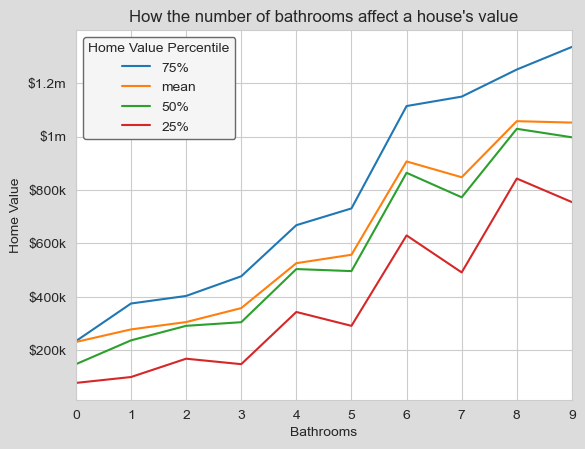

In [20]:
fig, ax = plt.subplots(facecolor='gainsboro', edgecolor='dimgray')
sns.set_style('whitegrid', rc={'figure.facecolor':'gainsboro'})
sns.lineplot(ax=ax, data=bathrooms_df, x='comparison', y='75%', label = '75%').set(title="How the number of bathrooms affect a house's value")
sns.lineplot(ax=ax, data=bathrooms_df, x='comparison', y='mean', label = 'mean')
sns.lineplot(ax=ax, data=bathrooms_df, x='comparison', y='50%' , label = '50%')
sns.lineplot(ax=ax, data=bathrooms_df, x='comparison', y='25%', label = '25%')
plt.xlim(left=0, right =3)
plt.ylabel('Home Value')
plt.xlabel('Bathrooms')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.yticks([200000, 400000, 600000, 800000, 1000000, 1200000, ],['$200k','$400k','$600k','$800k','$1m','$1.2m'])
plt.legend(title="Home Value Percentile", framealpha=1, facecolor="whitesmoke", edgecolor='dimgray')
plt.show()

#### Q3 Statistical Test <a class="anchor" id="q_3_stats"></a>

In [21]:
#Establishes hypothesis variables
h0 = "Number of bathrooms and home value are independent."
ha = "Number of bathrooms and home value have a relationship."

In [22]:
#Stats test
s, p_val = stats.pearsonr(train['bathrooms'], train['tax_value'])

#### Q3 Answer <a class="anchor" id="q_3_ans"></a>

In [23]:
#Gives output of stats test
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Number of bathrooms and home value have a relationship.


### Question 4 <a class="anchor" id="q_4"></a>

Do the number of features affect the value of a home?

Features:
- Pool
- Spa/Hot tub
- Deck
- Garage

#### Q4 Visualization <a class="anchor" id="q_4_viz"></a>

In [24]:
feature_list = ['num_of_features']
target_col = 'tax_value'

In [25]:
feature_per_item = explore_relationships(feature_list, train, target_col)

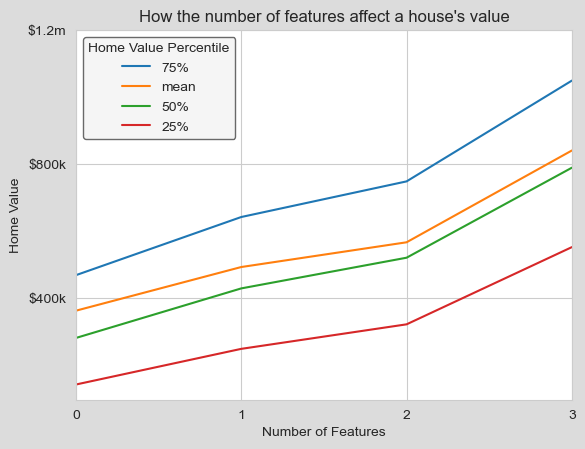

In [26]:
fig, ax = plt.subplots(facecolor='gainsboro', edgecolor='dimgray')
sns.set_style('whitegrid', rc={'figure.facecolor':'gainsboro'})
sns.lineplot(ax=ax, data=feature_per_item, x='comparison', y='75%', label = '75%').set(title="How the number of features affect a house's value")
sns.lineplot(ax=ax, data=feature_per_item, x='comparison', y='mean', label = 'mean')
sns.lineplot(ax=ax, data=feature_per_item, x='comparison', y='50%' , label = '50%')
sns.lineplot(ax=ax, data=feature_per_item, x='comparison', y='25%', label = '25%')
plt.xlim(left=0, right =3)
plt.ylabel('Home Value')
plt.xlabel('Number of Features')
plt.xticks([0, 1, 2, 3], ['0', '1', '2', '3'])
plt.yticks([400000,800000,1200000],['$400k','$800k','$1.2m'])
plt.legend(title="Home Value Percentile", framealpha=1, facecolor="whitesmoke", edgecolor='dimgray')
plt.show()

#### Q4 Statistical Test <a class="anchor" id="q_4_stats"></a>

In [27]:
#Establishes hypothesis variables
h0 = "Number of features and home value are independent."
ha = "Number of features and home value have a relationship."

In [28]:
#Stats test
s, p_val = stats.pearsonr(train['num_of_features'], train['tax_value'])

In [29]:
#Gives output of stats test
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Number of features and home value have a relationship.


#### Q4 Answer <a class="anchor" id="q_4_ans"></a>

## Explore summary <a class="anchor" id="explore2"></a>

Request to find county:

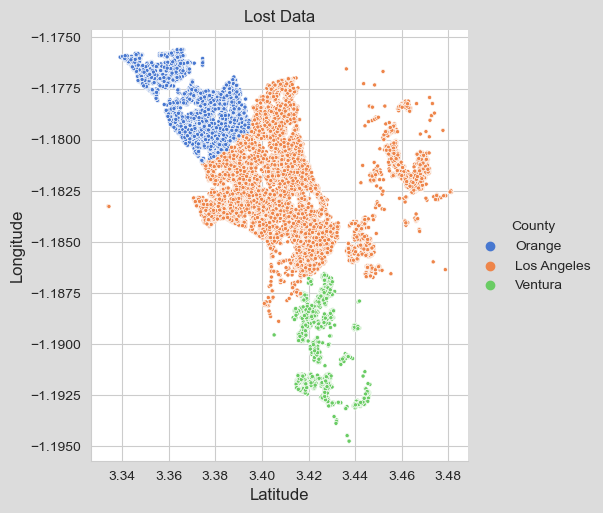

In [30]:
sns.set_style('whitegrid', rc={'figure.facecolor':'gainsboro'})
sns.relplot(data= train, x=train.latitude, y=train.longitude, hue=train.County, marker='.', palette='muted')
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.title('Lost Data')
plt.show()

My happy accident:

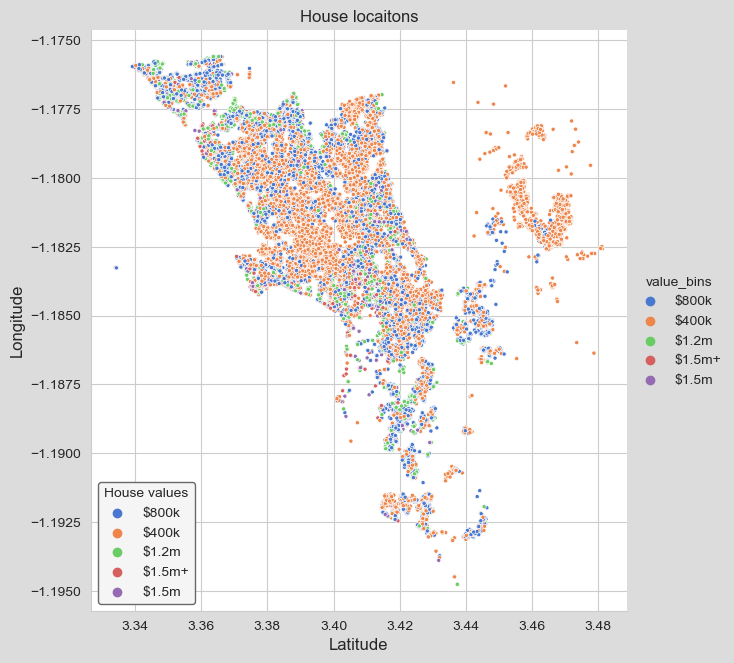

In [31]:
sns.set_style('whitegrid', rc={'figure.facecolor':'gainsboro'})
fig = sns.relplot(data = train, x='latitude', y='longitude', height=6.5, hue='value_bins', marker='.', palette='muted')
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.title("House locaitons")
plt.legend(title="House values", framealpha=1, facecolor="whitesmoke", edgecolor='dimgray')
plt.show()

## Modeling <a class="anchor" id="modeling"></a>

### Preparing the data for modeling

In [32]:
#Copies dataframe so I don't mess up the origional
ml_df = df.copy()

In [33]:
#Gets rid of the fluff
ml_df = df.drop(columns=['transactiondate', 'sqft_bins', 'value_bins', 'County'])

In [34]:
#Best models:
#ml_df = df.drop(columns=['transactiondate', 'sqft_bins', 'value_bins', 'County'])

#### Creating dummy columns for catagorical data

In [35]:
#Checks output
ml_df

,tax_value,bedrooms,bathrooms,sqft,hottub_spa,deck,garagecarcnt,pool,latitude,longitude,has_garages,num_of_features
0,1023282.0,4.0,3.5,3100.0,0,0,2.0,0,3.363493,-1.178692,1,1
1,464000.0,2.0,1.0,1465.0,0,0,1.0,0,3.444927,-1.192815,1,1
2,564778.0,3.0,2.0,1243.0,0,0,2.0,1,3.388617,-1.178232,1,2
3,145143.0,4.0,3.0,2376.0,0,0,0.0,1,3.424518,-1.182407,0,1
4,773303.0,4.0,3.0,2962.0,0,0,0.0,1,3.414520,-1.181798,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
50180,346534.0,4.0,2.0,1633.0,0,0,0.0,0,3.387081,-1.180709,0,0
50181,354621.0,2.0,2.0,1286.0,0,0,0.0,0,3.424537,-1.182824,0,0
50182,67205.0,4.0,2.0,1612.0,0,0,2.0,0,3.430014,-1.187063,1,1
50183,49546.0,3.0,1.0,1032.0,0,0,0.0,0,3.404089,-1.180382,0,0


In [36]:
#Builds dummy columns
ml_df = pd.get_dummies(columns=['bedrooms', 'bathrooms', 'num_of_features', 'garagecarcnt'], data=ml_df)

In [37]:
# best model so far:
# ml_df = pd.get_dummies(columns=['bedrooms', 'bathrooms', 'num_of_features', 'garagecarcnt'], data=ml_df)

In [38]:
#Splits data
train, val, test = train_validate(ml_df)

#### Scaling the columns with continuous data

In [39]:
#Scaling the data
train, val, test = scale_zillow(train, val, test, scaler_model = 3, cont_columns = ['sqft'])

In [40]:
#Ensuring transoform happened correctly
train.head()

,tax_value,sqft,hottub_spa,deck,pool,latitude,longitude,has_garages,bedrooms_0.0,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bathrooms_0.0,bathrooms_1.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,bathrooms_5.0,num_of_features_0,num_of_features_1,num_of_features_2,num_of_features_3,garagecarcnt_0.0,garagecarcnt_1.0,garagecarcnt_2.0,garagecarcnt_3.0,garagecarcnt_4.0,garagecarcnt_5.0,garagecarcnt_6.0,garagecarcnt_7.0,garagecarcnt_8.0,garagecarcnt_9.0,garagecarcnt_13.0
21639,650000.0,0.230444,0,0,0,3.371242,-1.179713,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
45333,404515.0,0.926004,0,0,0,3.359588,-1.176451,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
23805,755447.0,0.486258,0,0,0,3.411112,-1.183276,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
30476,346902.0,-0.014799,0,0,1,3.444295,-1.183886,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3516,613911.0,0.260042,0,0,0,3.352055,-1.177014,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Seperating the target data from the features

In [41]:
#Splits out target feature for machine learning models
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test(train, val, test, target_col)

#### Feature Selection

In [42]:
# Future development

### Introduction <a class="anchor" id="m_intro"></a>

### Baseline <a class="anchor" id="baseline"></a>

In [43]:
#Eastablishes the standard to beat
baseline = find_baseline(y_train)

RMSE Mean training baseline: 349,233
*****************************************
RMSE Median training baseline: 357,982


In [44]:
#metrics
rmse_scores = []

### Model 1 <a class="anchor" id="mod_1"></a>

#### LinearRegression(OLS)

In [45]:
#Builds machine learning model
lm = LinearRegression(normalize=True)

In [46]:
#Fits model to train data
lm.fit(X_train, y_train)

LinearRegression(normalize=True)

In [47]:
#Train
lm_preds = pd.DataFrame({'actual':y_train})

In [48]:
#Train
lm_preds['pred_lm'] = lm.predict(X_train)

In [49]:
#Gathers metrics for comparison
lm_val_preds = pd.DataFrame({'actual':y_val})

In [50]:
#Validate
lm_val_preds['lm_val_preds'] = lm.predict(X_val)

In [51]:
#Validate
lm_val_preds.head()

,actual,lm_val_preds
31550,146801.0,92746.0
9606,241193.0,323010.0
33721,264220.0,170024.0
11212,649348.0,550852.0
17823,52320.0,273284.0


In [52]:
#Train
rmse_train = mean_squared_error(lm_preds['actual'], lm_preds['pred_lm'], squared=False) 

In [53]:
#Validate
rmse_val = mean_squared_error(lm_val_preds['actual'], lm_val_preds['lm_val_preds'], squared=False) 

In [54]:
#Gathers metrics for comparison
rmse_scores.append({'Model':'OLS Linear',
                    'RMSE on Train': round(rmse_train,0),
                    'RMSE on Validate': round(rmse_val,0)})

In [55]:
#Checks output
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 280467.0,
  'RMSE on Validate': 280286.0}]

### Model 2 <a class="anchor" id="mod_2"></a>

#### LassoLars

In [56]:
#Builds machine learning model
lars = LassoLars(alpha=.25)

In [57]:
#Fits model to train data
lars.fit(X_train, y_train)

LassoLars(alpha=0.25)

In [58]:
#Train
ll_preds = pd.DataFrame({'actual':y_train})

In [59]:
#Train
ll_preds['pred_ll'] = lars.predict(X_train)

In [60]:
#Validate
ll_val_preds = pd.DataFrame({'actual':y_val})

In [61]:
#Validate
ll_val_preds['ll_val_preds'] = lars.predict(X_val)

In [62]:
#Train
rmse_train = mean_squared_error(ll_preds['actual'], ll_preds['pred_ll'], squared=False) 

In [63]:
#Validate
rmse_val = mean_squared_error(ll_val_preds['actual'], ll_val_preds['ll_val_preds'], squared=False) 

In [64]:
#Gathers metrics for comparison
rmse_scores.append({'Model':'Lasso Lars',
                    'RMSE on Train': round(rmse_train,0),
                    'RMSE on Validate': round(rmse_val,0)})

In [65]:
#Checks output
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 280467.0,
  'RMSE on Validate': 280286.0},
 {'Model': 'Lasso Lars',
  'RMSE on Train': 280470.0,
  'RMSE on Validate': 280280.0}]

### Model 3 <a class="anchor" id="mod_3"></a>

#### TweedieRegressor (GLM)

In [66]:
#Builds machine learning model
glm = TweedieRegressor(power=1, alpha=1)

In [67]:
#Fits model to train data
glm.fit(X_train, y_train)

TweedieRegressor(alpha=1, power=1)

In [68]:
#Train
glm_preds = pd.DataFrame({'actual':y_train})

In [69]:
#Train
glm_preds['pred_glm'] = glm.predict(X_train)

In [70]:
#Validate
glm_val_preds = pd.DataFrame({'actual':y_val})

In [71]:
#Validate
glm_val_preds['glm_val_preds'] = glm.predict(X_val)

In [72]:
#Train
rmse_train = mean_squared_error(glm_preds['actual'], glm_preds['pred_glm'], squared=False) 

In [73]:
#Validate
rmse_val = mean_squared_error(glm_val_preds['actual'], glm_val_preds['glm_val_preds'], squared=False) 

In [74]:
#Gathers metrics for comparison
rmse_scores.append({'Model':'Tweedie',
                    'RMSE on Train': round(rmse_train,0),
                    'RMSE on Validate': round(rmse_val,0)})

In [75]:
#Checks output
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 280467.0,
  'RMSE on Validate': 280286.0},
 {'Model': 'Lasso Lars',
  'RMSE on Train': 280470.0,
  'RMSE on Validate': 280280.0},
 {'Model': 'Tweedie', 'RMSE on Train': 284495.0, 'RMSE on Validate': 281784.0}]

### Model 4 <a class="anchor" id="mod_4"></a>

#### Polynomial Regression

In [76]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=1)

In [77]:
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

In [78]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_val)
X_test_degree2 = pf.transform(X_test)

#### Linear Regression

In [79]:
#Builds machine learning model
lm2 = LinearRegression(normalize=True)

In [80]:
#Fits model to train data
lm2.fit(X_train_degree2, y_train)

LinearRegression(normalize=True)

In [81]:
#Train
lm2_preds = pd.DataFrame({'actual':y_train})

In [82]:
#Train
lm2_preds['pred_lm2'] = lm2.predict(X_train_degree2)

In [83]:
#Validate
lm2_val_preds = pd.DataFrame({'actual':y_val})

In [84]:
#Validate
lm2_val_preds['lm2_val_preds'] = lm2.predict(X_validate_degree2)

In [85]:
#Train
rmse_train = mean_squared_error(lm2_preds['actual'], lm2_preds['pred_lm2'], squared=False) 

In [86]:
#Validate
rmse_val = mean_squared_error(lm2_val_preds['actual'], lm2_val_preds['lm2_val_preds'], squared=False) 

In [87]:
#Gathers metrics for comparison
rmse_scores.append({'Model':'Polynomial',
                    'RMSE on Train': round(rmse_train,0),
                    'RMSE on Validate': round(rmse_val,0)})

In [88]:
#Creates dataframe for plotting
rmse_scores = pd.DataFrame(rmse_scores)

In [89]:
#Calculates metrics for comparison
rmse_scores['Difference'] = round(rmse_scores['RMSE on Train'] - rmse_scores['RMSE on Validate'],2)

In [90]:
#Checks output
rmse_scores

,Model,RMSE on Train,RMSE on Validate,Difference
0,OLS Linear,280467.0,280286.0,181.0
1,Lasso Lars,280470.0,280280.0,190.0
2,Tweedie,284495.0,281784.0,2711.0
3,Polynomial,280467.0,280288.0,179.0


#### Plotting the results

In [91]:
#Gets numbers for min and max plotting ranges
rmse_min = min([rmse_scores['RMSE on Train'].min(), rmse_scores['RMSE on Validate'].min(), baseline])
rmse_max = max([rmse_scores['RMSE on Train'].max(), rmse_scores['RMSE on Validate'].max(), baseline])
rmse_range = rmse_max - rmse_min

In [92]:
#Plotting ranges
lower_limit = rmse_min * 0.8
upper_limit = rmse_max * 1.05

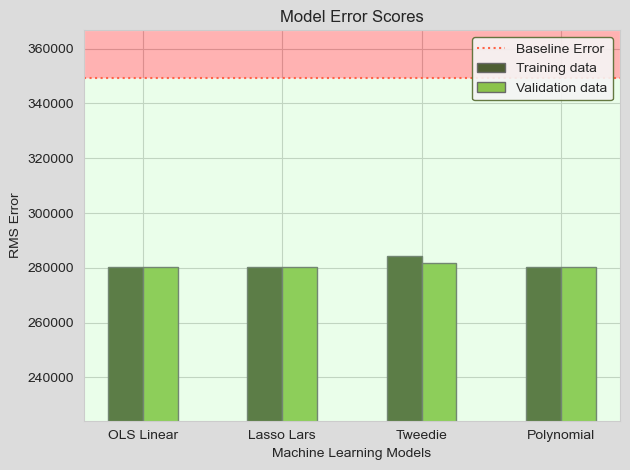

In [93]:
#Plotting code
x = np.arange(len(rmse_scores))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(facecolor="gainsboro")
rects1 = ax.bar(x - width/2, rmse_scores['RMSE on Train'], width, label='Training data', color='#4e5e33', edgecolor='dimgray') #Codeup dark green
rects2 = ax.bar(x + width/2, rmse_scores['RMSE on Validate'], width, label='Validation data', color='#8bc34b', edgecolor='dimgray') #Codeup light green

# Need to have baseline input:
plt.axhline(baseline, label="Baseline Error", c='tomato', linestyle=':')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.axhspan(0, baseline, facecolor='palegreen', alpha=0.2)
ax.axhspan(baseline, upper_limit, facecolor='red', alpha=0.3)
ax.set_ylabel('RMS Error')
ax.set_xlabel('Machine Learning Models')
ax.set_title('Model Error Scores')
ax.set_xticks(x, rmse_scores['Model'])

plt.ylim(bottom=lower_limit, top = upper_limit)

ax.legend(loc='upper right', framealpha=.9, facecolor="whitesmoke", edgecolor='darkolivegreen')

fig.tight_layout()
plt.savefig('best_model_all_features.png')
plt.show()


Takeaway: Longitude and Latitude help by -10,000

## Conclusion <a class="anchor" id="conclusion"></a>

- OLS Linear and Polynomial performed well on the training and validate data.
- Lasso Lars performed well on the train and validation sets.

### Background Info:

Home sales:
- 2021: $6.02 B, up 350%

Mortgages:
- 2021: $250 M, up 40%

Internet Media and Technology IMT:
- 2021: $1.9 B, up 30%

Zillow Statistics:
https://www.rubyhome.com/blog/zillow-stats/

Year	Revenue	Change

2022	$9.63 B

2021	$8.14 B

2020	$3.33 B

Source:
https://companiesmarketcap.com/zillow/revenue/#:~:text=Revenue%20for%20Zillow%20(Z)&text=In%202021%20the%20company%20made,that%20were%20of%20%243.33%20B.


### Summery <a class="anchor" id="c_summery"></a>

- The number of bedrooms, bathrooms, features and square footage all have a positive linear relationship with home value.
- Lasso Lars performed well on the train, validation and test data sets. RMSE of 286,891.

### Recommendations <a class="anchor" id="c_recs"></a>

- Zillow makes 6 of their 8 billion dollars annual from property sales.
- 6% commission.

- Create 'Zillow Pages™' of locally available resources to improve your home.
- Targeted advertising to conduct home improvements during the fall and winter.

**"If you are planning to sell, improve your homes now."**

- Target areas with higher property values. Less affected by high interest rates.
- Aligns the incentives of Zillow and home owners:
    - sell quickly
    - best price

### Next Steps <a class="anchor" id="c_steps"></a>

- Explore location based modeling
- Time series analysis on when sales occure
    - No sales were listed for Sept, Oct, Nov or Dec.
- A function to automatically map fips to county and state

# Review previous feedback